# Hack the job market like a data scientist
## Market
How big is the market for a job-seeker's profile? How does it differ by region?

Only gross numbers are available from BLS
http://www.bls.gov/emp/ep_table_201.htm
- How many jobs in a sector?
Prof Services has 19m out of 150m total, or 15%.
http://www.bls.gov/oes/current/oes_nat.htm
- Computer and math
4m total employment, avg $86k a year

## Problem
How big is the job market for a job-seeker's skills, location and salary expectations?

## Solution
Text analysis and parse phrases through Indeed search. Summarize value of various phrases. Calculate market size from Indeed "Jobs above this amount" grid.


In [134]:
import pandas as pd
import requests
import lxml.html
from lxml.html.clean import Cleaner
import re
#import json
from time import sleep
from random import randint
import csv
import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
import scipy as sp
import scipy.stats as stats

from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline
# Set figure width to 12 and height to 9
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size


In [56]:
file = 'data/resume.txt'

f = open(file, 'r')


text = f.read()


#vect = CountVectorizer(ngram_range=(1, 2))

blob = TextBlob(text)
phrases = blob.noun_phrases

# for phrase in phrases:
#     print(phrase)
    
print(phrases)

['doll', 'kilbourne pl', 'washington dc', 'steven @ clearskies.co 202-386-0190 stevendoll github.com/stevendoll www.linkedin.com/ /in/stevendoll', 'mba', 'it', 'tangible business value', 'agile app development', 'enterprise software', 'cloud migrations', 'data science', 'custom software', 'security threats', 'real time', 'faa', 'peacekeeping', 'three-person team', 'it', 'emergency management center', 'early-stage', 'washington', 'dc lightsense', 'cleantech', 'semifinalist', 'ir', 'internet', 'iot', 'clear skies', 'founder institute-winning', 'energy efficiency technologies', 'rigil', 'corporation /', 'senior product', 'washington', 'dc', 'mobile application development team', 'cmmi', 'agile methods', 'aws', 'jira', 'pivotal tracker', 'behavior-driven', 'working', 'cio', 'aviation', '$ 9m portfolio', 'it', 'business case', 'contract structure', 'peacekeeping', 'field it specialist', 'addis ababa', 'ethiopia', 'field it specialist', 'ip', 'open-source software', 'new technologies', 'assi

In [69]:
def parse_job_words(keywords):
    
    base_url = 'http://www.indeed.com/jobs?q="'
    url_suffix = '"&l=Washington%2C+DC'
    headers = {'User-agent':'Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.9.0.1) Gecko/2008071615 Fedora/3.0.1-1.fc9 Firefox/3.0.1'}

    main_results = []

    for term in keywords:
    
        dat = {}

        url = ''.join([base_url, str(term.replace(' ','+')), url_suffix])

        print('Processing term %s %s' % (term.replace('+',' '), url))

        try:

            #random time delay for scraping
            sleep(randint(0,5))

            r = requests.get(url, headers=headers)
            
            doc = lxml.html.fromstring(r.content)

            # request status
            dat['term'] = term.replace('+',' ')
            #dat['status_code'] = r.status_code
            dat['url'] = url
            
            if len(doc.cssselect('#SALARY_rbo ul li')) > 1:

                for i in range(0,len(doc.cssselect('#SALARY_rbo ul li'))):

                    row = doc.cssselect('#SALARY_rbo ul li')[i].text_content().strip()

                    dat['salary'+str(i)] = re.compile('\$(.*)\+').findall(row)[0].replace(',','')
                    dat['positions'+str(i)] = re.compile('\((.*)\)').findall(row)[0].replace(',','')

                main_results.append(dat)

        except:
            print('Error getting detail for term %s %s' % (term.replace('+',' '), url))



    print('Done processing job listings')
    return main_results


if __name__ == '__main__':
    
    #get results
    #keywords = ['machine learning','"ruby+on+rails"','"data+science"','wordpress','"energy+efficiency"','startup','mba','aws','cloud','cloud+mba','bdd','python','python+pandas','scikit-learn','mba+"data+science"','startup+data+science']
    
    keywords = phrases #[0:5]
    
    keywords = parse_job_words(keywords)
    
    df = pd.DataFrame.from_dict(keywords, dtype=None)
    
    print(df.head())

    #create filename
    #filename = location.replace('--', '_').replace('-', '_').lower() + '.csv'
    filename = '2016-06-20-job-words.csv'
    
    #get all keys
    headings = sorted(list(set().union(*(d.keys() for d in keywords))))
    
    #write to csv file
    with open(filename, 'w') as output_file:
        dict_writer = csv.DictWriter(output_file, headings)
        dict_writer.writeheader()
        dict_writer.writerows(keywords)



Processing term doll http://www.indeed.com/jobs?q="doll"&l=Washington%2C+DC
Processing term kilbourne pl http://www.indeed.com/jobs?q="kilbourne+pl"&l=Washington%2C+DC
Processing term washington dc http://www.indeed.com/jobs?q="washington+dc"&l=Washington%2C+DC
Processing term steven @ clearskies.co 202-386-0190 stevendoll github.com/stevendoll www.linkedin.com/ /in/stevendoll http://www.indeed.com/jobs?q="steven+@+clearskies.co+202-386-0190+stevendoll+github.com/stevendoll+www.linkedin.com/+/in/stevendoll"&l=Washington%2C+DC
Processing term mba http://www.indeed.com/jobs?q="mba"&l=Washington%2C+DC
Processing term it http://www.indeed.com/jobs?q="it"&l=Washington%2C+DC
Processing term tangible business value http://www.indeed.com/jobs?q="tangible+business+value"&l=Washington%2C+DC
Processing term agile app development http://www.indeed.com/jobs?q="agile+app+development"&l=Washington%2C+DC
Processing term enterprise software http://www.indeed.com/jobs?q="enterprise+software"&l=Washingto

In [70]:
file = '2016-06-20-job-words.csv'
df = pd.read_csv(file)


In [71]:
# clean up df

df.fillna(value=0, inplace=True)

df['positions0'] = df.positions0.astype(int)
df['positions1'] = df.positions1.astype(int)
df['positions2'] = df.positions2.astype(int)
df['positions3'] = df.positions3.astype(int)
df['positions4'] = df.positions4.astype(int)
df['salary0'] = df.salary0.astype(int)
df['salary1'] = df.salary1.astype(int)
df['salary2'] = df.salary2.astype(int)
df['salary3'] = df.salary3.astype(int)
df['salary4'] = df.salary4.astype(int)

In [72]:
for index, row in df.iterrows():
    salaries = []
    
    for i in range(0,5):
        #if i = 4 or positions of next element is 0, then this is the top bin
        if i == 4 or row['positions'+str(i+1)] == 0:
            salaries += row['positions'+str(i)] * [(row['salary'+str(i)] + (row['salary'+str(i)] - row['salary'+str(i-1)])*1.25)]        
        else:    
            salaries += row['positions'+str(i)] * [(row['salary'+str(i)] + row['salary'+str(i+1)])/2]

    salary_series = pd.Series(salaries)
    
    df.loc[index, 'mean'] = salary_series.mean()
    df.loc[index, 'positions'] = salary_series.count()
    df.loc[index, 'std'] = salary_series.std()
    
    df.loc[index, 'above_100k'] = (1-stats.norm.cdf(100000, loc=salary_series.mean(), scale=salary_series.std()))*salary_series.count()
    df.loc[index, 'above_105k'] = (1-stats.norm.cdf(105000, loc=salary_series.mean(), scale=salary_series.std()))*salary_series.count()
    df.loc[index, 'above_110k'] = (1-stats.norm.cdf(110000, loc=salary_series.mean(), scale=salary_series.std()))*salary_series.count()
    df.loc[index, 'above_115k'] = (1-stats.norm.cdf(115000, loc=salary_series.mean(), scale=salary_series.std()))*salary_series.count()
    df.loc[index, 'above_120k'] = (1-stats.norm.cdf(120000, loc=salary_series.mean(), scale=salary_series.std()))*salary_series.count()
    df.loc[index, 'above_125k'] = (1-stats.norm.cdf(125000, loc=salary_series.mean(), scale=salary_series.std()))*salary_series.count()
    df.loc[index, 'above_130k'] = (1-stats.norm.cdf(130000, loc=salary_series.mean(), scale=salary_series.std()))*salary_series.count()
    df.loc[index, 'above_135k'] = (1-stats.norm.cdf(135000, loc=salary_series.mean(), scale=salary_series.std()))*salary_series.count()
    df.loc[index, 'above_140k'] = (1-stats.norm.cdf(140000, loc=salary_series.mean(), scale=salary_series.std()))*salary_series.count()
    df.loc[index, 'above_150k'] = (1-stats.norm.cdf(150000, loc=salary_series.mean(), scale=salary_series.std()))*salary_series.count()
    


In [73]:
# calibrate the top tier skew from outliers
df['top_tier_dev'] = 0
df.loc[df.salary4 == 115000, 'top_tier_dev'] = df['above_115k'] - df['positions4']
df.loc[df.salary4 == 120000, 'top_tier_dev'] = df['above_120k'] - df['positions4']
df.loc[df.salary4 == 125000, 'top_tier_dev'] = df['above_125k'] - df['positions4']
df.loc[df.salary4 == 130000, 'top_tier_dev'] = df['above_130k'] - df['positions4']
df.loc[df.salary4 == 135000, 'top_tier_dev'] = df['above_135k'] - df['positions4']
df.top_tier_dev.sum()

-73.22147699676412

In [147]:
df_summary = df[df.positions > 25][['term','mean','positions','std','above_110k','above_120k','above_130k']].groupby('term').first().sort_values('mean', ascending=False)[0:15]
df_summary['bubble_size'] = df_summary['above_120k'].apply(lambda x : np.sqrt(x) * 300)
#df_summary.reset_index(level=2, drop=True)
df_summary.index


Index(['cloud migrations', 'senior product', 'aws', 'agile methods', 'behavior-driven', 'open-source software', 'data science', 'enterprise software', 'pivotal tracker', 'security threats', 'jira', 'mba', 'business case', 'lead engineer', 'iot'], dtype='object', name='term')

## Ideas?
- Which skills cluster together? (Can scrape listing page and count other terms)
- Heat map? Red is a skill cluster with large high-paid jobs


In [148]:
# google trends slope

google_trends = pd.Series({'cloud migrations':-0.2, 'senior product':0, 'aws':0.8, 'agile methods':0.1, 'behavior-driven':0.05, 'open-source software':-0.05, 'data science':1, 'enterprise software':0, 'pivotal tracker':-0.1, 'security threats':0, 'jira':0.3, 'mba':-0.05, 'business case':0, 'lead engineer':0.15, 'iot':1.1}, name='trend')
df_summary = pd.concat([df_summary, google_trends], axis=1)


In [142]:
df_summary

,mean,positions,std,above_110k,above_120k,above_130k,bubble_size,trend
agile methods,104591.121495,321.0,8254.572066,82.224364,9.941744,0.334296,630.610617,0.10
aws,106526.894655,5819.0,11842.966308,2238.339551,742.702992,138.131334,5450.515543,0.80
behavior-driven,100654.205607,107.0,9203.775685,16.579686,1.902376,0.076525,275.853317,0.05
business case,95146.545031,1288.0,16090.013097,229.219150,78.845371,19.512800,1775.898323,0.00
cloud migrations,126637.931034,29.0,9797.636880,27.702569,21.777743,10.606530,933.332586,-0.20
data science,99225.778547,1156.0,14934.041760,272.024339,94.910920,22.735029,1948.444716,1.00
enterprise software,97567.148760,1452.0,13460.184618,258.205503,69.400067,11.596145,1666.134054,0.00
iot,93958.333333,240.0,15956.132113,37.766789,12.319544,2.867520,701.984152,1.10
jira,95590.741267,3521.0,9709.140172,242.569568,21.012217,0.693804,916.781698,0.30
lead engineer,94166.666667,321.0,15776.040807,50.646772,16.294788,3.711430,807.336063,0.15


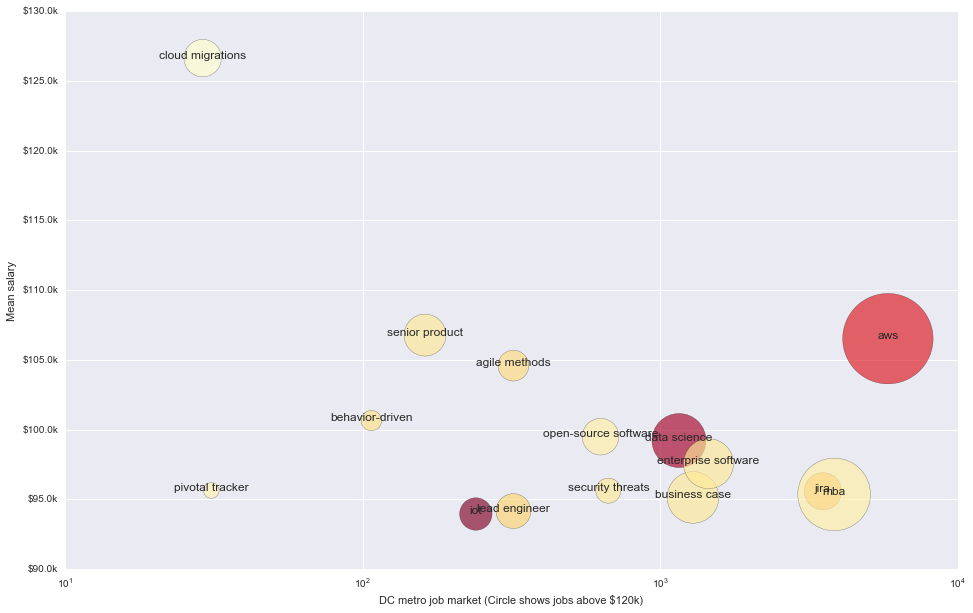

In [153]:
from math import sqrt
from matplotlib.ticker import FuncFormatter

def thousands(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fk' % (x*1e-3)

formatter = FuncFormatter(thousands)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(df_summary['positions'],df_summary['mean'], s=df_summary['bubble_size'], c=df_summary['trend'], cmap='YlOrRd', alpha=.65) # Added third variable income as size of the bubble
plt.ylabel('Mean salary')
plt.xlabel('DC metro job market (Circle shows jobs above $120k)')

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_alpha(0.75)

ax.yaxis.set_major_formatter(formatter)


for index, row in df_summary.iterrows():
    plt.text(row['positions'],row['mean'],index,size=12,horizontalalignment='center')

plt.show()